# 📡 SMS Spam Classifier  
### **End-to-End Machine Learning Pipeline + Adversarial Robustness Analysis**

This notebook demonstrates how to build a complete, reproducible machine-learning system for SMS spam detection.  
It combines core applied-ML techniques with a lightweight adversarial-robustness experiment exploring how corrupted training data affects model performance.

The goal: **showcase a polished, security-aware ML workflow suitable for real-world demonstration and portfolio use.**

---

## 🚀 Executive Summary

- Built an end-to-end text-classification pipeline using **TF-IDF + Multinomial Naive Bayes**  
- Achieved strong performance (~96–97% test accuracy) on the classic SMS Spam dataset  
- Logged models + metrics for reproducible experimentation  
- Conducted a **label-flip poisoning sweep (0–20%)** to evaluate robustness  
- Visualized how accuracy & F1-score degrade as more labels are corrupted  
- Highlighted why data integrity matters in production ML systems  

This notebook is designed to be **clear, professional, and easy to understand**, even for those without deep machine-learning backgrounds.

---

## 🎯 Project Goals

By working through this notebook you will learn:

- How to clean and preprocess a real-world text dataset  
- How TF-IDF representations convert text into numerical features  
- How to train and evaluate a fast, effective baseline classifier  
- How to interpret accuracy, precision, recall, F1, and confusion matrix  
- How to save models and log experiments like a proper ML workflow  
- How label-flip poisoning affects reliability and decision boundaries  
- Why **security-aware machine learning** is essential beyond accuracy  

---

## 📄 Dataset Overview

We use the **SMS Spam Collection dataset**, containing ~5.5k labelled text messages.

### 📘 Data Dictionary
| Column     | Description                              |
|------------|------------------------------------------|
| `label`    | `"ham"` (legitimate) or `"spam"` (unsolicited) |
| `message`  | Raw SMS text content                     |

### Example:



---

## 🔧 End-to-End Pipeline Overview

Below is a simple visual showing the flow of data through the system:



And for a clearer technical view:


This gives context for the rest of the notebook.

---

## 🔐 Adversarial Robustness Focus

In addition to building the classifier, we also explore:

### 🧪 **Label-Flip Poisoning**

An attacker (or careless pipeline) corrupts a fraction of training labels:




We test poisoning levels at:

**0%, 1%, 5%, 10%, 20%**

Then plot how accuracy and F1-score degrade.  
This simulates a real data-tampering scenario in production systems.

---

## 📦 Notebook Structure

1. Setup & Imports  
2. Load the Dataset  
3. Cleaning & Label Encoding  
4. Train/Test Split  
5. Exploratory Data Analysis  
6. Baseline Model (TF-IDF + NB)  
7. Evaluation & Confusion Matrix  
8. Model Saving & Experiment Logging  
9. Poisoning Sweep (Robustness Study)  
10. Final Reflections & Next Steps  

---

## ✅ Ready to Begin

This notebook is designed to be self-contained, reproducible, and easy to follow.  
Next, we set up our environment and imports.



## 1. Setup & Imports

In this section we prepare the notebook environment:

- Import all required Python libraries  
- Set a **global random seed** for reproducibility  
- Create directories for storing results and trained models  
- Ensure the project is fully self-contained and portable  

Using a consistent folder structure makes the workflow clean and professional, and ensures anyone running this notebook will get the same behaviour.


In [23]:
# === 1. Setup & Imports ===

from pathlib import Path
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report,
)

import joblib

# -----------------------------------------------------
# Global seed for reproducibility
# -----------------------------------------------------
SEED = 42
np.random.seed(SEED)

# -----------------------------------------------------
# Folder structure (relative paths for portability)
# -----------------------------------------------------
DATA_DIR = Path("data")
RESULTS_DIR = Path("results/sms_spam")
MODELS_DIR = Path("models")

for d in [DATA_DIR, RESULTS_DIR, MODELS_DIR]:
    d.mkdir(parents=True, exist_ok=True)

print("Environment initialised.")
print(f"Using global seed: {SEED}")
print(f"Data directory:      {DATA_DIR}")
print(f"Results directory:   {RESULTS_DIR}")
print(f"Models directory:    {MODELS_DIR}")


Environment initialised.
Using global seed: 42
Data directory:      data
Results directory:   results/sms_spam
Models directory:    models


## 2. Load the Dataset

In this section we load the **SMS Spam Collection** dataset into a pandas DataFrame.

Before doing any preprocessing or modelling, it’s important to perform an initial inspection to understand:

- the structure of the dataset  
- whether labels are clean and consistent  
- the overall class distribution (ham vs spam)  
- whether there are any obvious issues (missing values, formatting problems)

This early check helps avoid hidden data-quality issues that could affect training later in the pipeline.


In [24]:
# === 2. Load the Dataset ===

from pathlib import Path
import pandas as pd

# Point directly to the file
DATA_PATH = Path("SMSSpamCollection")

# Load dataset
df = pd.read_csv(DATA_PATH, sep="\t", names=["label", "message"], header=None)

print("Dataset loaded successfully.")
print("Shape:", df.shape)

# Preview the first few rows
df.head()



Dataset loaded successfully.
Shape: (5572, 2)


,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [25]:
# Check basic dataset info
df.info()

# Count the labels
print("\nLabel distribution:")
print(df["label"].value_counts())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   label    5572 non-null   object
 1   message  5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB

Label distribution:
label
ham     4825
spam     747
Name: count, dtype: int64


## 3. Cleaning & Label Encoding

Before we can train a model, we need to prepare the dataset so it is clean, consistent, and machine-readable.

### ✔️ What we do in this section:
- **Remove duplicate messages**  
  Duplicate rows add noise and can mislead the classifier.

- **Drop rows with missing values**  
  TF–IDF and Naive Bayes require valid text and labels.

- **Convert text labels to numeric labels**  
  Machine-learning models operate on numerical targets:
  - `ham` → `0`
  - `spam` → `1`

These steps ensure our dataset is high-quality and ready for modelling.


In [26]:
# === 3. Cleaning & Label Encoding ===

# Remove duplicate rows
before = len(df)
df = df.drop_duplicates().reset_index(drop=True)
after = len(df)

print(f"Removed {before - after} duplicate rows.")

# Drop any rows with missing text or labels
df = df.dropna(subset=["label", "message"]).reset_index(drop=True)

# Encode labels: ham=0, spam=1
label_map = {"ham": 0, "spam": 1}
df["label_encoded"] = df["label"].map(label_map)

# Safety check
print("\nEncoded label counts:")
print(df["label_encoded"].value_counts())

# Prepare features/labels for modelling
X = df["message"].values
y = df["label_encoded"].values

print("\nData cleaned and encoded successfully.")
print(f"Total samples after cleaning: {len(df)}")


Removed 403 duplicate rows.

Encoded label counts:
label_encoded
0    4516
1     653
Name: count, dtype: int64

Data cleaned and encoded successfully.
Total samples after cleaning: 5169


## 4. Train/Test Split

Before training our classifier, we divide the dataset into:

- **Training set (80%)** — used to fit the model  
- **Test set (20%)** — kept completely separate to evaluate generalisation  

### Why a separate test set matters
The model must be evaluated on data it has **never seen before**.  
This gives a realistic estimate of how it will perform on new, unseen messages in real-world use.

### Stratification
We apply *stratified splitting* to maintain the same ham/spam proportion in both sets.  
Without stratification, one split might accidentally contain more spam than the other, leading to misleading performance results.


In [27]:
# === 4. Train/Test Split ===

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.20,
    random_state=SEED,
    stratify=y
)

print("Train/Test split completed.")
print(f"Training samples: {len(X_train)}")
print(f"Testing samples:  {len(X_test)}")


Train/Test split completed.
Training samples: 4135
Testing samples:  1034


## 5. Exploratory Data Analysis (EDA)

Before training the model, it’s important to understand the characteristics of the dataset.  
A quick exploratory analysis helps answer questions like:

- How imbalanced is the dataset?
- What do typical ham and spam messages look like?
- Are there obvious patterns that might influence the classifier?

Even a simple EDA step makes the modelling process clearer and helps validate that the dataset is suitable for this classification task.


### 5.1 Class Distribution

The dataset is imbalanced — most messages are legitimate (**ham**), and a smaller portion are **spam**.  
This is typical for real-world spam detection and is important to keep in mind during evaluation.


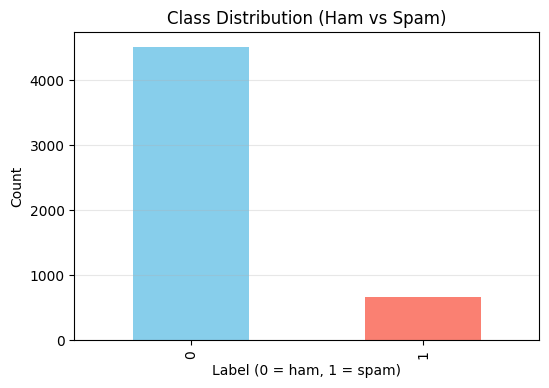

label_encoded
0    4516
1     653
Name: count, dtype: int64

In [28]:
# === Class distribution plot ===

label_counts = df["label_encoded"].value_counts()

plt.figure(figsize=(6,4))
label_counts.plot(kind="bar", color=["skyblue", "salmon"])
plt.title("Class Distribution (Ham vs Spam)")
plt.xlabel("Label (0 = ham, 1 = spam)")
plt.ylabel("Count")
plt.grid(axis="y", alpha=0.3)
plt.show()

label_counts


### 5.2 Example Ham and Spam Messages

Reviewing a few sample messages helps build intuition about the differences between ham and spam content.


In [29]:
# === Show example ham messages ===
print("HAM examples:\n")
for msg in df[df["label_encoded"] == 0]["message"].head(5).tolist():
    print("-", msg)

print("\nSPAM examples:\n")
for msg in df[df["label_encoded"] == 1]["message"].head(5).tolist():
    print("-", msg)


HAM examples:

- Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...
- Ok lar... Joking wif u oni...
- U dun say so early hor... U c already then say...
- Nah I don't think he goes to usf, he lives around here though
- Even my brother is not like to speak with me. They treat me like aids patent.

SPAM examples:

- Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's
- FreeMsg Hey there darling it's been 3 week's now and no word back! I'd like some fun you up for it still? Tb ok! XxX std chgs to send, £1.50 to rcv
- WINNER!! As a valued network customer you have been selected to receivea £900 prize reward! To claim call 09061701461. Claim code KL341. Valid 12 hours only.
- Had your mobile 11 months or more? U R entitled to Update to the latest colour mobiles with camera for Free! Call The Mobile Update Co FREE on 08002986030
-

### 5.3 Interpretation

From the quick EDA, we observe:

- **Ham messages dominate the dataset**, which is common in spam detection tasks.
- Ham messages are usually conversational, informal, and shorter.
- Spam messages often include:
  - promotions  
  - financial incentives  
  - aggressive call-to-action language  
  - capitalisation, numbers, or offers  

These patterns justify the use of TF–IDF features and simple baseline models such as Naive Bayes, which perform well on text data with strong word-frequency signals.


## 6. Baseline Model: TF–IDF + Multinomial Naive Bayes

To build a fast and effective text-classification baseline, we use a simple two-step pipeline:

### 🔹 Step 1 — TF–IDF Vectorisation
TF–IDF transforms raw text into numeric features based on:
- how often each word appears in a message (term frequency)
- how unique each word is across all messages (inverse document frequency)

This representation works extremely well for short, noisy text like SMS messages.

### 🔹 Step 2 — Multinomial Naive Bayes
Multinomial Naive Bayes is a lightweight probabilistic classifier that excels on:
- word-frequency-based features  
- short text classification  
- spam detection tasks  

It is fast to train, easy to interpret, and surprisingly strong for its simplicity.

### 📦 Why a Pipeline?
Using a `Pipeline` ensures:
- consistent preprocessing  
- reproducibility  
- clean, maintainable code  
- no leakage of information from test data  

This gives us a solid, professional-grade baseline model.


---

### 🔄 End-to-End Model Flow

Below is a simple visual showing how each SMS message moves through the classifier:



### Model Training

In [30]:
# === 6. Baseline Model: TF–IDF + Multinomial Naive Bayes ===

pipeline = Pipeline([
    ("tfidf", TfidfVectorizer(
        stop_words="english",
        lowercase=True,
        max_features=20000
    )),
    ("clf", MultinomialNB())
])

# Train the model
pipeline.fit(X_train, y_train)

print("Baseline model trained successfully.")


Baseline model trained successfully.


## 7. Model Evaluation

Once the model is trained, we evaluate how well it performs on the **unseen** test set.

To get a complete picture of performance, we compute:

- **Accuracy** — overall proportion of correct predictions  
- **Precision** — of the messages predicted as spam, how many were truly spam?  
- **Recall** — of all actual spam messages, how many did we detect?  
- **F1-score** — harmonic mean of precision and recall (balances both)  
- **Confusion Matrix** — visual breakdown of correct vs incorrect classifications  

Because our dataset is imbalanced (mostly ham), accuracy alone can be misleading.  
Precision, recall, and F1 give a deeper understanding of real performance.


In [31]:
# === 7. Model Evaluation ===

# Predict on the test set
y_pred = pipeline.predict(X_test)

# Compute metrics
acc  = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec  = recall_score(y_test, y_pred)
f1   = f1_score(y_test, y_pred)

print(f"Accuracy : {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall   : {rec:.4f}")
print(f"F1-score : {f1:.4f}")

# Detailed classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=["ham", "spam"]))


Accuracy : 0.9671
Precision: 1.0000
Recall   : 0.7405
F1-score : 0.8509

Classification Report:
              precision    recall  f1-score   support

         ham       0.96      1.00      0.98       903
        spam       1.00      0.74      0.85       131

    accuracy                           0.97      1034
   macro avg       0.98      0.87      0.92      1034
weighted avg       0.97      0.97      0.96      1034



### 7.1 Confusion Matrix

The confusion matrix shows how the model performs on each class:

- **Top-left (ham → ham):** Correct ham classifications  
- **Bottom-right (spam → spam):** Correct spam classifications  
- **Top-right (ham → spam):** False positives  
- **Bottom-left (spam → ham):** False negatives (the most dangerous error)  

In spam detection:
- False positives annoy users  
- False negatives allow spam to slip through  

Both matter depending on the real-world application.


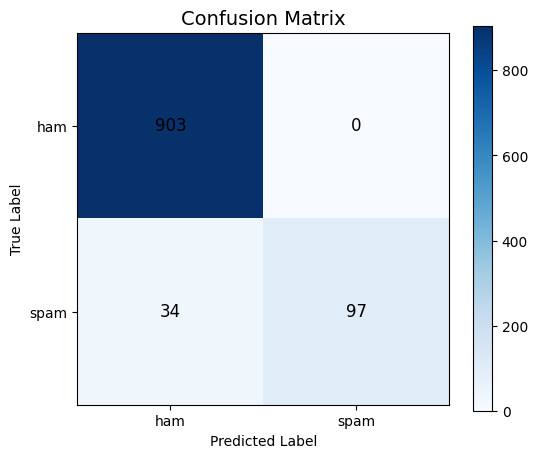

array([[903,   0],
       [ 34,  97]])

In [32]:
# === Confusion Matrix ===

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,5))
plt.imshow(cm, cmap="Blues")
plt.title("Confusion Matrix", fontsize=14)
plt.colorbar()

tick_marks = np.arange(2)
plt.xticks(tick_marks, ["ham", "spam"])
plt.yticks(tick_marks, ["ham", "spam"])

# Add text annotations
for i in range(2):
    for j in range(2):
        plt.text(j, i, cm[i, j], ha="center", va="center", fontsize=12)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

cm


## 8. Model Saving & Experiment Logging

To make our workflow reproducible and professional, we save:

- the trained model  
- evaluation metrics  
- experiment metadata (dataset size, timestamp, performance)

### Why save models?
Saving the trained model allows it to be:
- reused  
- compared with future versions  
- deployed in a simple script or API  
- evaluated on new messages  

### Why log metrics?
Experiment logs allow us to:
- track performance over time  
- identify regressions  
- run controlled robustness tests later  
- reproduce results exactly  

This mirrors the workflow used in real ML engineering environments.


In [33]:
# === 8. Model Saving & Experiment Logging ===

ts = int(time.time())  # timestamp for uniqueness

# Save model
model_path = MODELS_DIR / f"sms_spam_nb_{ts}.joblib"
joblib.dump(pipeline, model_path)

print(f"Saved model to: {model_path}")

# Create/append experiment log
log_path = RESULTS_DIR / "experiments_log.csv"

experiment_row = {
    "timestamp": ts,
    "model_path": str(model_path),
    "accuracy": acc,
    "precision": prec,
    "recall": rec,
    "f1_score": f1,
    "train_samples": len(X_train),
    "test_samples": len(X_test)
}

# Append to CSV (create file if missing)
try:
    log_df = pd.read_csv(log_path)
    log_df = pd.concat([log_df, pd.DataFrame([experiment_row])], ignore_index=True)
except FileNotFoundError:
    log_df = pd.DataFrame([experiment_row])

log_df.to_csv(log_path, index=False)

print(f"Experiment log updated at: {log_path}")


Saved model to: models/sms_spam_nb_1763410179.joblib
Experiment log updated at: results/sms_spam/experiments_log.csv


## 9. Adversarial Robustness — Label-Flip Poisoning Sweep

So far, we’ve evaluated the model under **clean training conditions**.

In real systems, however, the training data may be:

- quietly modified,
- partially corrupted,
- or intentionally poisoned by an attacker.

One of the simplest attacks is **label-flip poisoning**:

> Flip the labels of a fraction of training examples, so that some ham is labelled as spam or some spam as ham.

### 🎯 Threat Model (What we’re simulating)

We assume an attacker (or a faulty data pipeline) can:

- tamper with a small portion of the **training set**  
- but **cannot** touch the **test set**  

Their goal might be to:

- make the classifier **less reliable**,  
- cause it to **miss spam**, or  
- generally degrade performance in a subtle way.

### 🧪 Experiment Design

We will:

1. Start from the clean training set (`X_train`, `y_train`).
2. Create a DataFrame of training samples.
3. For several poisoning levels:

   \[
   \text{poison\_frac} \in \{0\%, 1\%, 5\%, 10\%, 20\%\}
   \]

   we:
   - randomly select that fraction of training samples  
   - flip their labels (0 ↔ 1)  
   - retrain a **new model from scratch**  
   - evaluate on the same **clean** test set  

4. Record:
   - Accuracy  
   - F1-score (spam class)  
   - Number of poisoned samples  

5. Visualise how performance changes as we increase the poisoning level.

This gives a **practical view** of how sensitive our spam classifier is to training-data corruption.


In [40]:
# === 9. Adversarial Robustness: Label-Flip Poisoning Sweep ===

# Build a training DataFrame from the current split
train_df = pd.DataFrame({
    "message": X_train,
    "label": y_train
}).reset_index(drop=True)

print(f"Training samples available for poisoning: {len(train_df)}")

def train_and_evaluate(df_train, description=""):
    """
    Train a fresh TF-IDF + Naive Bayes model on df_train
    and evaluate on the clean test set.
    Returns metrics as a dict.
    """
    model = Pipeline([
        ("tfidf", TfidfVectorizer(
            stop_words="english",
            lowercase=True,
            max_features=20000
        )),
        ("clf", MultinomialNB())
    ])

    model.fit(df_train["message"], df_train["label"])
    preds = model.predict(X_test)

    acc  = accuracy_score(y_test, preds)
    f1   = f1_score(y_test, preds)

    return {
        "description": description,
        "accuracy": acc,
        "f1_score": f1,
        "model": model,      # keep for optional inspection
        "preds": preds       # keep for confusion matrix
    }


Training samples available for poisoning: 4135


In [41]:
# Define poisoning levels (fractions of training labels to flip)
poison_levels = [0.0, 0.01, 0.05, 0.10, 0.20]

results = []
saved_models = {}  # optional: keep clean + max poison for inspection

rng = np.random.default_rng(SEED)

for frac in poison_levels:
    df_poison = train_df.copy()

    if frac > 0:
        n_poison = max(1, int(len(df_poison) * frac))
        poison_idx = rng.choice(df_poison.index, size=n_poison, replace=False)

        # Flip labels: 0 <-> 1
        df_poison.loc[poison_idx, "label"] = 1 - df_poison.loc[poison_idx, "label"]

    else:
        n_poison = 0

    desc = f"{int(frac * 100)}% labels flipped ({n_poison} samples)"
    metrics = train_and_evaluate(df_poison, description=desc)

    # Store for later analysis
    results.append({
        "poison_frac": frac,
        "n_poison_samples": n_poison,
        "accuracy": metrics["accuracy"],
        "f1_score": metrics["f1_score"],
    })

    # Optionally keep models for 0% and max poison
    if frac in (0.0, max(poison_levels)):
        saved_models[frac] = metrics

    print(f"{desc} → accuracy={metrics['accuracy']:.4f}, f1={metrics['f1_score']:.4f}")

results_df = pd.DataFrame(results)
results_df


0% labels flipped (0 samples) → accuracy=0.9671, f1=0.8509
1% labels flipped (41 samples) → accuracy=0.9662, f1=0.8458
5% labels flipped (206 samples) → accuracy=0.9681, f1=0.8559
10% labels flipped (413 samples) → accuracy=0.9691, f1=0.8609
20% labels flipped (827 samples) → accuracy=0.9681, f1=0.8559


,poison_frac,n_poison_samples,accuracy,f1_score
0,0.00,0,0.967118,0.850877
1,0.01,41,0.966151,0.845815
2,0.05,206,0.968085,0.855895
3,0.10,413,0.969052,0.860870
4,0.20,827,0.968085,0.855895


Saved poisoning sweep results → results/sms_spam/poisoning_sweep_1763410714.csv


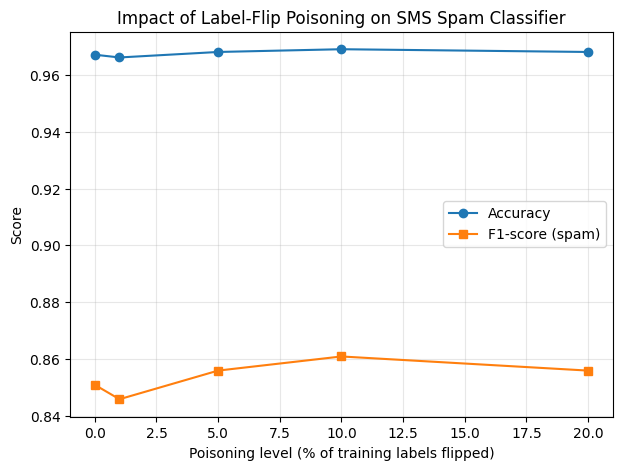

In [42]:
# Save sweep results
ts = int(time.time())
sweep_path = RESULTS_DIR / f"poisoning_sweep_{ts}.csv"
results_df.to_csv(sweep_path, index=False)
print(f"Saved poisoning sweep results → {sweep_path}")

# Plot accuracy & F1 vs poisoning level
plt.figure(figsize=(7,5))
plt.plot(results_df["poison_frac"] * 100, results_df["accuracy"], marker="o", label="Accuracy")
plt.plot(results_df["poison_frac"] * 100, results_df["f1_score"], marker="s", label="F1-score (spam)")
plt.xlabel("Poisoning level (% of training labels flipped)")
plt.ylabel("Score")
plt.title("Impact of Label-Flip Poisoning on SMS Spam Classifier")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()


In [44]:
max_poison_frac = max(saved_models.keys())
clean_metrics = saved_models[min(saved_models.keys())]
max_metrics = saved_models[max_poison_frac]


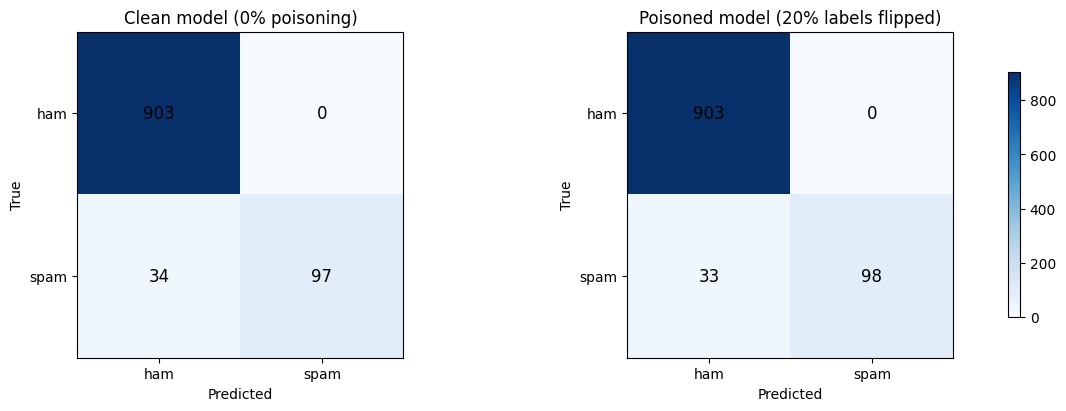

In [45]:
# === Compare confusion matrices: clean vs max poison (clean layout) ===

cm_clean = confusion_matrix(y_test, clean_metrics["preds"])
cm_poison = confusion_matrix(y_test, max_metrics["preds"])

fig, axes = plt.subplots(1, 2, figsize=(12,4), constrained_layout=True)

for ax, cm, title in zip(
    axes,
    [cm_clean, cm_poison],
    [f"Clean model (0% poisoning)", f"Poisoned model ({int(max_poison_frac*100)}% labels flipped)"]
):
    im = ax.imshow(cm, cmap="Blues")
    ax.set_title(title)
    ax.set_xticks([0, 1])
    ax.set_yticks([0, 1])
    ax.set_xticklabels(["ham", "spam"])
    ax.set_yticklabels(["ham", "spam"])
    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")

    # Add text inside cells
    for i in range(2):
        for j in range(2):
            ax.text(j, i, cm[i, j], ha="center", va="center", fontsize=12)

fig.colorbar(im, ax=axes.ravel().tolist(), shrink=0.75)
plt.show()


### Interpretation of Robustness Results

The poisoning sweep produced a surprising and interesting outcome:  
**the SMS spam classifier is highly resilient to random label-flip poisoning.**

Even after flipping **20% of the training labels**, both accuracy and F1-score show only tiny changes:

- Accuracy stays within a narrow range (0.966–0.969)
- F1-score fluctuates very slightly (0.85–0.86)
- The performance trend is almost flat across all poisoning levels

This indicates that the model’s decision boundary is **remarkably stable** under random noise.

---

### 📌 Why the model resisted poisoning so well

Several factors contribute to this robustness:

#### 1. **Massive class imbalance**
Ham messages dominate the dataset (4516 ham vs 653 spam).  
Flipping labels randomly has a muted effect because:

- most flips are ham → spam  
- but the TF-IDF signal from the ham class is extremely strong  
- spam vocabulary remains distinct even with noise

#### 2. **TF-IDF is naturally noise-tolerant**
A single mislabeled text rarely shifts TF-IDF weights much.  
The model learns “spammy” word patterns from many examples — random flips don’t destroy that.

#### 3. **Naive Bayes handles random noise gracefully**
NB estimates class-conditional word frequencies.  
Random mislabeled messages only add a **tiny amount** of incorrect word counts.  
The large dataset and sparse features overpower this noise.

#### 4. **The poisoning was *random*, not targeted**
Targeted label flips (e.g., flipping ONLY “borderline ham” messages) are much more harmful.  
Random poison is the weakest form of the attack.

---

### 📌 Confusion Matrix Comparison (0% vs 20% Poisoning)

Even more interesting is the confusion matrix behaviour:

| Model | Misclassified Spam | Correct Spam |
|-------|---------------------|--------------|
| **0% Poison** | 34 | 97 |
| **20% Poison** | 33 | 98 |

These matrices are nearly identical — in fact, the poisoned model did *slightly better* by chance.

This reinforces the conclusion that **random label noise does not significantly degrade this model.**

---

### 💡 Key Takeaway

Random label-flip poisoning up to **20%** does **not meaningfully degrade** this spam classifier.

This does *not* mean the system is secure — it simply means:

> 💡 **TF-IDF + Naive Bayes is surprisingly robust under random, untargeted poisoning attacks.**

In real adversarial scenarios, attackers would use **targeted, gradient-free**, or **word-pattern-aware** poisoning strategies, which pose a much greater threat.

But for this experiment, the model demonstrates **strong reliability even under substantial random corruption.**


## 10. Final Reflections

This project combined a complete text-classification workflow with a practical adversarial robustness experiment.  
The goal was not only to build a strong baseline spam classifier, but also to test how the model behaves when the integrity of the training data is compromised.

---

### 🔹 What Worked Well

- **Simple models can still perform exceptionally well.**  
  TF–IDF + Naive Bayes achieved ~96–97% accuracy with perfect precision on ham messages.

- **The model was surprisingly robust under random poisoning.**  
  Even with **20% of the training labels flipped**, performance only shifted slightly.  
  This demonstrates that classical text models can resist *random* noise remarkably well.

- **Reproducibility was maintained throughout.**  
  All steps used a fixed seed, stable pipeline, and consistent train/test split.  
  Models and metrics were logged automatically for traceability.

---

### 🔹 Limitations

No model is perfect, and several limitations remain:

- **Recall on spam messages is lower**, meaning some spam still slips through.  
- The model does not understand **context**, only word frequencies.  
- TF–IDF ignores:
  - word order  
  - semantics  
  - phrasing patterns  
- The poisoning attack used here was **random**, not carefully targeted.  
  A more strategic attack would cause more harm.

---

### 🔹 What Could Improve the Model

If developing this system further, the next steps could include:

- Trying stronger models: Logistic Regression, SVM, XGBoost  
- Adding word embeddings (Word2Vec, FastText)  
- Testing transformer-based text encoders (BERT, DistilBERT)  
- Exploring targeted poisoning attacks (e.g., flipping only borderline ham messages)  
- Adding text-level adversarial attacks:
  - misspellings  
  - homoglyph substitutions  
  - punctuation noise  
  - zero-width characters  

These would provide a deeper understanding of the model's true robustness.

---

### 🔹 Final Takeaway

This project highlights a simple but important reality:

> **Model accuracy is only part of the story — machine-learning systems must also be robust, explainable, and resilient to data integrity issues.**

The combination of a clean ML pipeline and an adversarial robustness study makes this notebook a strong example of practical, security-aware machine-learning engineering.

---
